<h1><center>TASK 2 NIGHT CITY CLUSTERING</center> </h1>
<h4>Name-Aayush Srivastava <br> Roll No- 23AG10003 </h4>

<h3><b>You might need to run the file multiple times to get the correct centroid as we have initially chosen random centroids until convergence</b> </h3>
<h4>That is unfortunately the drawback of K means </h4> 

Firstly we import the images from our path (images are in Images folder) using the PIL libray. We convert it into greyscale using the .convert('L') method.<br>
The numpy array is of size 64x64<br>
__[ReferredCode](https://python-code.dev/articles/1357367)__

we will also store our image data in a list so that we can utilise it later on

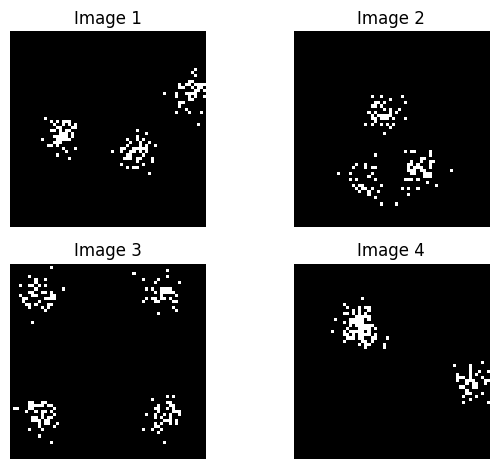

In [395]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# list of paths 
image_paths = ["Images/1.png", "Images/2.png", "Images/3.png", "Images/4.png"]
image_data = []
for i, image_path in enumerate(image_paths):
    img = Image.open(image_path)
    img_gray = img.convert('L') # grayscale conversion
    img_array = np.array(img_gray) # numpy arrray 
    
    # plotting
    plt.subplot(2, 2, i+1)
    plt.imshow(img_array, cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis('off')

    image_data.append(img_array) # storing data

plt.tight_layout()
plt.show()

Now we will try to gather illuminated points i.e points where the grayscale has a value >0 (this is out threshold)

In [396]:
# threshold for illumination
threshold = 0  # any pixel with intensity greater than 0 is considered illuminated

# storing illuminated points of each image in a dictionary for easy access
illuminated_points_dict = {}
for i, img_array in enumerate(image_data):
    illuminated_points = np.column_stack(np.where(img_array > threshold))
    illuminated_points_dict[i] = illuminated_points


plotting our illuminated points to check whether they match , say using green colour

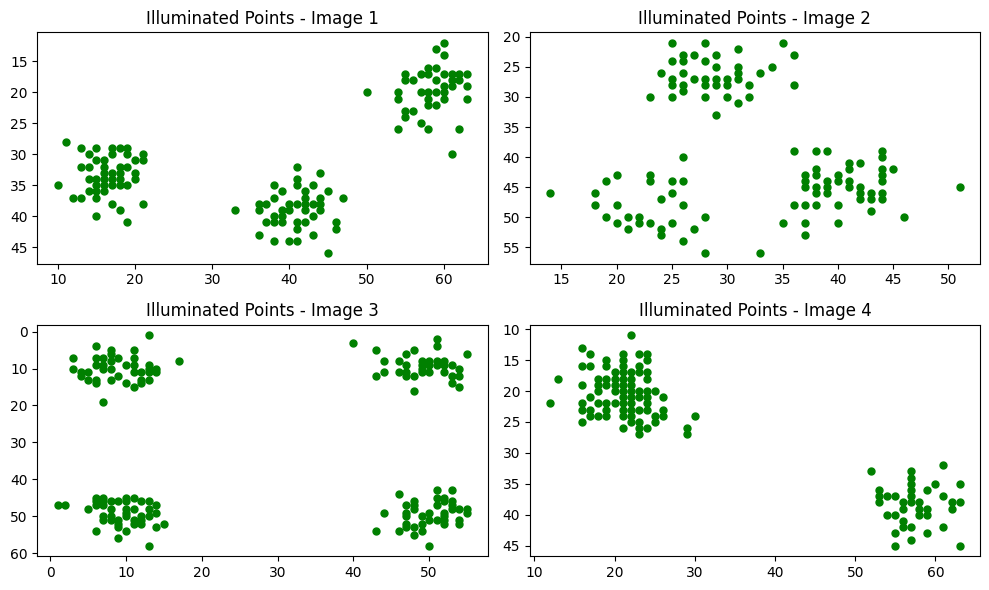

In [397]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
for i, (illuminated_points, ax) in enumerate(zip(illuminated_points_dict.values(), axs.flatten()), start=1):
    ax.scatter(illuminated_points[:, 1], illuminated_points[:, 0], color='green', s=25)
    ax.set_title(f"Illuminated Points - Image {i}")
    ax.invert_yaxis()  # Invert y-axis to match image coordinates

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-info">
<h3> K-means Clustering Algorithm </h3>
</div>

__[refer video for logic](https://youtu.be/4b5d3muPQmA)__ <br>
The following pseudocode will run us down on what we will do: <br>
1. Initialize K cluster centroids randomly
2. Repeat until convergence:
a. Assign each data point to the nearest centroid <br>
b. Recompute the centroids as the mean of the data points assigned to each
centroid <br>
c. Check for convergence criteria (e.g., small change in centroids or fixed number <br>
of iterations)
3. Return the final centroids and cluster assignments

__[code referred from github](https://github.com/bheemnitd/2D-KMeans-Clustering/blob/master/kmeansClustrering.ipynb)__

In [398]:
import numpy as np

def initialize_centroids(data, k):
    centroids_idx = np.random.choice(data.shape[0], size=k, replace=False)
    centroids = data[centroids_idx]
    return centroids

def assign_to_clusters(data, centroids):
    distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
    labels = np.argmin(distances, axis=0)
    return labels

def update_centroids(data, labels, k):
    centroids = np.array([data[labels == i].mean(axis=0) if np.sum(labels == i) > 0 else np.nan for i in range(k)])
    return centroids

def Kmeans(data, k, max_iterations=100, tol=1e-4):
    if k > len(data):
        raise ValueError("Number of clusters (k) cannot be greater than the number of data points.")
    centroids = initialize_centroids(data, k)
    for _ in range(max_iterations):
        labels = assign_to_clusters(data, centroids)
        new_centroids = update_centroids(data, labels, k)
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    return centroids, labels



Now let us try to see what happens when we try this using k=3 on say image 1 and 4

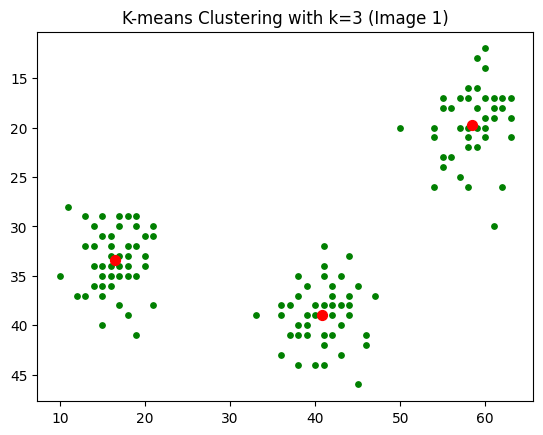

In [399]:
# Extract illuminated points for images from the dictionary
illuminated_points_image1 = illuminated_points_dict[0]  #
illuminated_points_image2 = illuminated_points_dict[1]
illuminated_points_image3 = illuminated_points_dict[2]
illuminated_points_image4 = illuminated_points_dict[3]
# Apply K-means with k=3 for trial
k = 3
centroids, labels = Kmeans(illuminated_points_image1, k)

# Plot the illuminated points and centroids
plt.scatter(illuminated_points_image1[:, 1], illuminated_points_image1[:, 0], color='green', s=15)
plt.scatter(centroids[:, 1], centroids[:, 0], color='red', marker='o', s=50)
plt.title("K-means Clustering with k=3 (Image 1)")
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.show()


It clearly seems to work great on image 1 but what about image 4 ? 

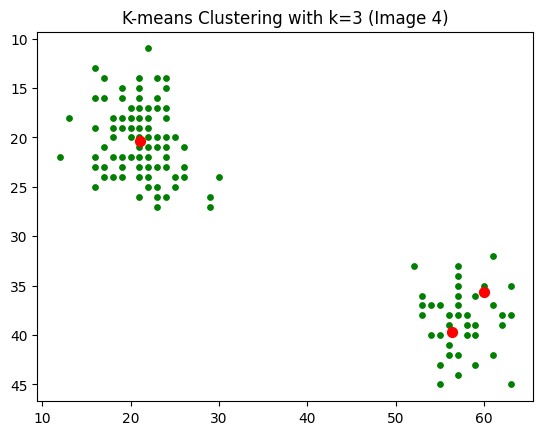

In [400]:
k = 3
centroids, labels = Kmeans(illuminated_points_image4, k)
plt.scatter(illuminated_points_image4[:, 1], illuminated_points_image4[:, 0], color='green', s=15)
plt.scatter(centroids[:, 1], centroids[:, 0], color='red', marker='o', s=50)
plt.title("K-means Clustering with k=3 (Image 4)")
plt.gca().invert_yaxis() 
plt.show()

clearly we have now run into a problem , it identifies as 3 centroids even though we can visually tell that it is 2!

to fix this we will implement a cluster identification algorithm , the one we will use is known as the Elbow method to find the optimal value of k

<div class="alert alert-block alert-info">
<h3> Elbow Method for optimal K value </h3>
</div>

__[reference to logic](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/)__ <br>
the following pseudocode is used:
Pseudo Code

1. Initialize an empty list to store the within-cluster sum of squares (WCSS) for each
value of K
2. For k = 1 to max_clusters:

Perform clustering using K-means algorithm with k clusters
Calculate the within-cluster sum of squares (WCSS) for the clustering `
result
Append the WCSS value to the list

3. Plot the WCSS values against the number of clusters (k)
4. Identify the "elbow point" where the rate of decrease in WCSS slows down
5. Return the optimal number of clusters (k) corresponding to the elbow point

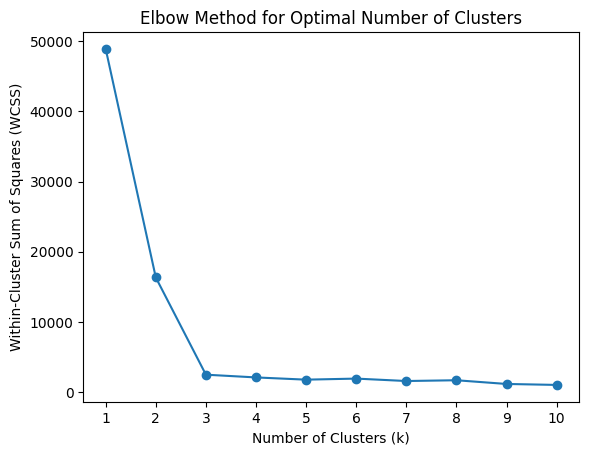

Optimal number of clusters for image 1: 2


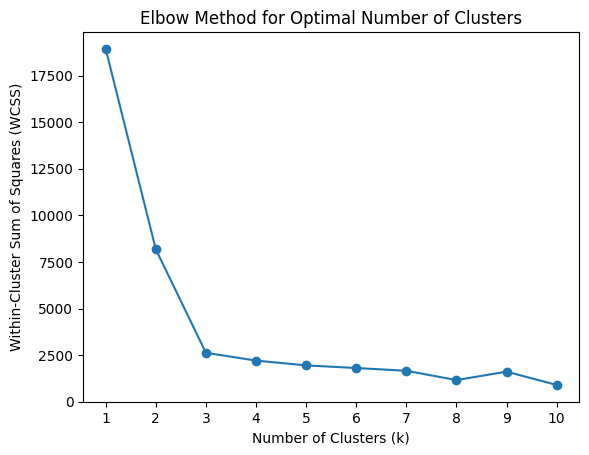

Optimal number of clusters for image 2: 2


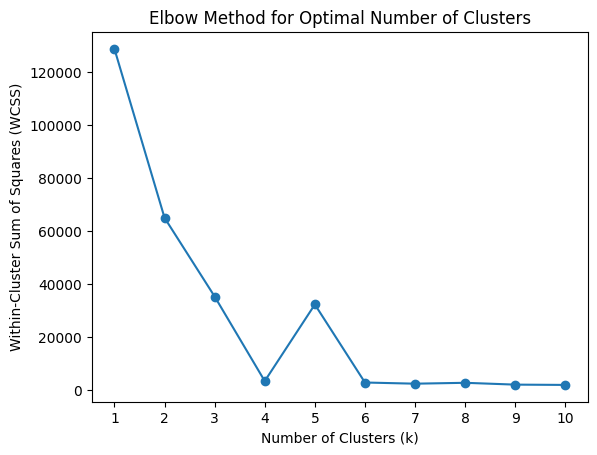

Optimal number of clusters for image 3: 4


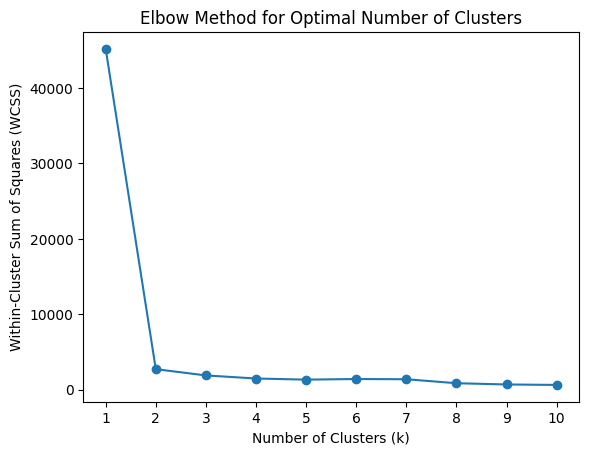

Optimal number of clusters for image 4: 2
Optimal number of clusters for each image: {0: 2, 1: 2, 2: 4, 3: 2}


In [401]:

def calculate_wcss(data, centroids, labels):
    wcss = 0
    for i in range(len(centroids)):
        cluster_points = data[labels == i]
        wcss += np.sum((cluster_points - centroids[i])**2)
    return wcss

def find_optimal_clusters(data, max_clusters):
    wcss_values = []
    for k in range(1, max_clusters + 1):
        # Apply K-means with k clusters
        centroids, labels = Kmeans(data, k)
        
        # Calculate the within-cluster sum of squares (WCSS)
        wcss = calculate_wcss(data, centroids, labels)
        
        # Append the WCSS value to the list
        wcss_values.append(wcss)
    
    # Plot the WCSS values against the number of clusters (k)
    plt.plot(range(1, max_clusters + 1), wcss_values, marker='o')
    plt.title("Elbow Method for Optimal Number of Clusters")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
    plt.xticks(range(1, max_clusters + 1))
    plt.show()
    
     # Here, we'll find the point where the rate of decrease in WCSS slows down the most, but also considering the earliest point
    deltas = np.diff(wcss_values, 2)
    max_delta_idx = np.argmax(deltas) + 2  # Add 2 because we calculated deltas with a shift of 2
    
    # Return the optimal number of clusters
    optimal_k = max_delta_idx
    return optimal_k, wcss_values

# Use the function to find the optimal number of clusters
# Dictionary to store optimal number of clusters for each image
optimal_k_dict = {}
max_clusters=10
# Loop over each image's illuminated points
for i, illuminated_points in illuminated_points_dict.items():
    optimal_k, _ = find_optimal_clusters(illuminated_points, max_clusters)
    optimal_k_dict[i] = optimal_k
    print(f"Optimal number of clusters for image {i+1}: {optimal_k}")

print("Optimal number of clusters for each image:", optimal_k_dict)



as we can see this algorithm doesnt prove correct 100% of the time so we will finally initialise our optimal k dictionary with the k value that were repeated most often during our tests and that have produced,
we can use other algos like silhoutte scores or something else but we will stick to elbow for now

In [402]:
# Dictionary to store optimal number of clusters for each image
optimal_k_dict = {0: 3, 1: 3, 2: 4, 3: 2}

# Loop over each image's illuminated points
for i, illuminated_points in illuminated_points_dict.items():
    optimal_k = optimal_k_dict.get(i, 3)  # Default to 3 if not specified
    print(f"Optimal number of clusters for image {i+1}: {optimal_k}")

print("Optimal number of clusters for each image:", optimal_k_dict)


Optimal number of clusters for image 1: 3
Optimal number of clusters for image 2: 3
Optimal number of clusters for image 3: 4
Optimal number of clusters for image 4: 2
Optimal number of clusters for each image: {0: 3, 1: 3, 2: 4, 3: 2}


Now it time to plot our data finally using Kmeans function to get centroids and then we will report the distance between these centroids in a tabular format

centroids have been marked numerically for better showcase

Distance between centroids for Image 1:
Centroid No | Centroid No | Distance
     1      |      2      |    24.969670633907217
     1      |      3      |    26.075866303439494
     2      |      3      |    44.158775128406916


Distance between centroids for Image 2:
Centroid No | Centroid No | Distance
     1      |      2      |    17.83254182556197
     1      |      3      |    22.95926449112495
     2      |      3      |    21.923285609373703


Distance between centroids for Image 3:
Centroid No | Centroid No | Distance
     1      |      2      |    44.18655912100946
     1      |      3      |    47.128827780239455
     1      |      4      |    44.37096716886419
     2      |      3      |    5.66513825514012
     2      |      4      |    40.65664510164555
     3      |      4      |    37.72006309909942


Distance between centroids for Image 4:
Centroid No | Centroid No | Distance
     1      |      2      |    40.68147748702136




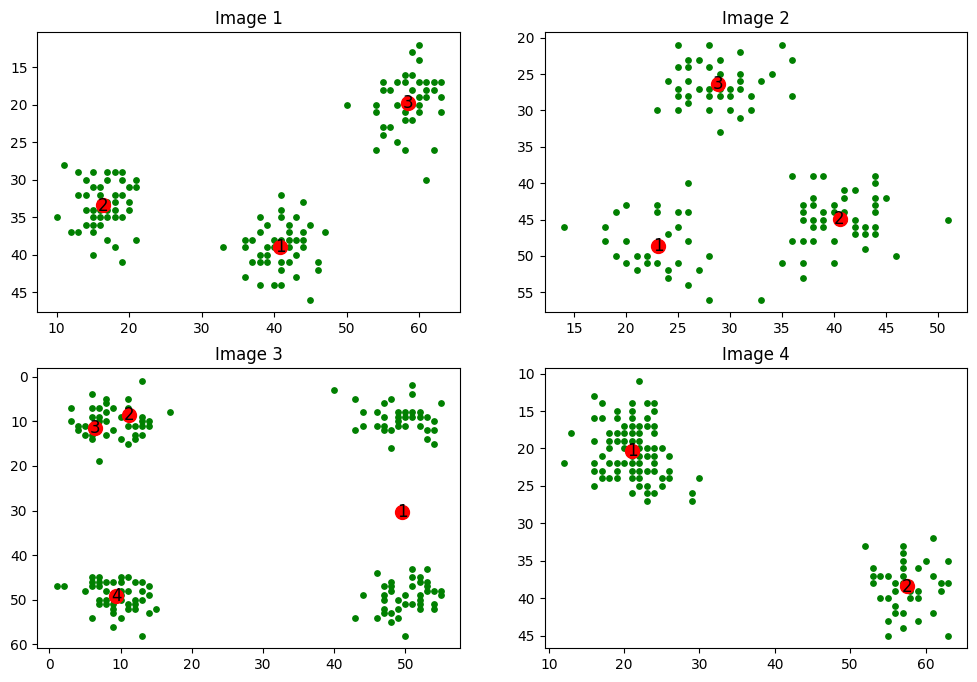

In [403]:
#list for centroids
all_centroids = []

# looping over illumninated points
for i, illuminated_points in illuminated_points_dict.items():
    # getting optimal k for each image 
    optimal_k = optimal_k_dict.get(i)
    
    # Apply K-means with optimal_k clusters
    centroids, _ = Kmeans(illuminated_points, optimal_k)
    
    # Store centroids for current image
    all_centroids.append(centroids)

    # Calculate distances between centroids
    distances = []
    for k in range(len(centroids)):
        for l in range(k + 1, len(centroids)):
            distance = np.linalg.norm(centroids[k] - centroids[l])
            distances.append((k + 1, l + 1, distance))

    # trying to print ina  tabular format
    print(f"Distance between centroids for Image {i+1}:")
    print("Centroid No | Centroid No | Distance")
    for distance in distances:
        print(f"     {distance[0]}      |      {distance[1]}      |    {distance[2]}")
    print("\n")
    

# plotting image with centroids and labelling them numerically

plt.figure(figsize=(12, 8))
for i, (illuminated_points, centroids) in enumerate(zip(illuminated_points_dict.values(), all_centroids), start=1):
    plt.subplot(2, 2, i)
    plt.scatter(illuminated_points[:, 1], illuminated_points[:, 0], color='green', s=15)
    plt.scatter(centroids[:, 1], centroids[:, 0], color='red', marker='o', s=100)
    for j, centroid in enumerate(centroids):
        plt.text(centroid[1], centroid[0], f"{j+1}", color='black', fontsize=12, ha='center', va='center')
    plt.title(f"Image {i}")
    plt.gca().invert_yaxis()  # inverting y axis

plt.show()


<h2>Can we improve on this?</h2><br>
<h3><b>Drawback of standard K-means algorithm:</b></h3><br>

" One disadvantage of the K-means algorithm is that it is sensitive to the initialization of the centroids or the mean points. So, if a centroid is initialized to be a “far-off” point, it might just end up with no points associated with it, and at the same time, more than one cluster might end up linked with a single centroid. Similarly, more than one centroid might be initialized into the same cluster resulting in poor clustering. For example, consider the images shown below. "- __[source](https://www.geeksforgeeks.org/ml-k-means-algorithm/)__

<div class="alert alert-block alert-info">
<h3> K-means++ and Silhoutte score for better optimization</h3>
</div>

<h3>Kmeans++ Implementation </h3>

the reffered code for K means ++ and logic is __[here](https://www.geeksforgeeks.org/ml-k-means-algorithm/)

here is the pseudocode <br>
1.Randomly select the first centroid from the data points.<br>
2.For each data point compute its distance from the nearest, previously chosen centroid.<br>
3.Select the next centroid from the data points such that the probability of choosing a point as centroid is directly proportional to its distance from the nearest, previously chosen centroid. (i.e. the point having maximum distance from the nearest centroid is most likely to be selected next as a centroid)<br>
4.Repeat steps 2 and 3 until k centroids have been sampled

In [404]:
import numpy as np

def initialize_centroids_kmeans_pp(data, k):
    centroids = []
    # Randomly select the first centroid from the data points
    centroids.append(data[np.random.randint(data.shape[0])])
    
    for _ in range(1, k):
        # Compute distances from each data point to the nearest centroid
        distances = np.array([min(np.linalg.norm(centroid - point) for centroid in centroids) for point in data])
        # Select the next centroid based on probability proportional to distance squared
        probabilities = distances**2 / np.sum(distances**2)
        next_centroid_idx = np.random.choice(len(data), p=probabilities)
        centroids.append(data[next_centroid_idx])
    
    return np.array(centroids)

# Rest of the code remains the same as your previous Kmeans implementation
def Kmeans_pp(data, k, max_iterations=100, tol=1e-4):
    if k > len(data):
        raise ValueError("Number of clusters (k) cannot be greater than the number of data points.")
    centroids = initialize_centroids_kmeans_pp(data, k)
    for _ in range(max_iterations):
        labels = assign_to_clusters(data, centroids)
        new_centroids = update_centroids(data, labels, k)
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    return centroids, labels


here we can already see this algo being better than k means as it almost never produces wrong centroids for the clusters

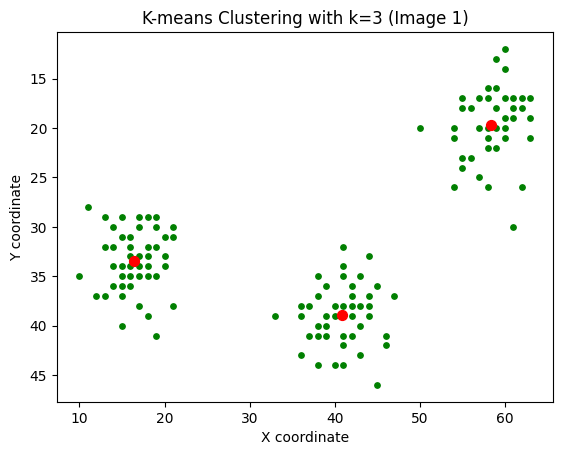

In [405]:
k = 3
centroids, labels = Kmeans_pp(illuminated_points_image1, k)
# Plot the illuminated points and centroids
plt.scatter(illuminated_points_image1[:, 1], illuminated_points_image1[:, 0], color='green', s=15)
plt.scatter(centroids[:, 1], centroids[:, 0], color='red', marker='o', s=50)
plt.title("K-means Clustering with k=3 (Image 1)")
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.show()


<h3>Silhouette Score implementation</h3>

__[for logic](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=The%20silhouette%20score%20is%20specialized,distance%20or%20the%20Manhattan%20distance.)__

Pseudocode below<br>
1. For each data point in the dataset:<br>
    2. Calculate the average distance (a) between the data point and all other data points within the same cluster.<br>
    3. Calculate the average distance (b) between the data point and all data points in the nearest neighboring cluster.<br>
    4. Calculate the silhouette score (s) for the data point using the formula:<br>
       s = (b - a) / max(a, b)<br>
5. Calculate the overall silhouette score by averaging the silhouette scores of all data points.<br>
6. Repeat steps 1-5 for different numbers of clusters (k).<br>
7. Select the number of clusters (k) that maximizes the overall silhouette score.<br>

In [407]:
def calculate_silhouette_score(data, labels, centroids):
    distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
    cluster_labels = np.argmin(distances, axis=0)
    silhouette_scores = []
    for i in range(len(data)):
        intra_cluster_dist = np.mean([np.linalg.norm(data[i] - data[j]) for j in range(len(data)) if labels[j] == labels[i] and i != j])
        nearest_cluster_dist = min([np.mean([np.linalg.norm(data[i] - data[j]) for j in range(len(data)) if cluster_labels[j] == c]) for c in range(len(centroids)) if c != labels[i]])
        silhouette_scores.append((nearest_cluster_dist - intra_cluster_dist) / max(nearest_cluster_dist, intra_cluster_dist))
    return np.mean(silhouette_scores)

def find_optimal_clusters(data, max_clusters):
    silhouette_scores = []
    for k in range(2, max_clusters + 1):
        centroids, labels = Kmeans_pp(data, k)
        silhouette_score = calculate_silhouette_score(data, labels, centroids)
        silhouette_scores.append(silhouette_score)
    
    optimal_k = np.argmax(silhouette_scores) + 2  # Add 2 because range starts from 2
    return optimal_k, silhouette_scores

optimal_k_dict = {}
max_clusters = 10
for i, illuminated_points in illuminated_points_dict.items():
    optimal_k, _ = find_optimal_clusters(illuminated_points, max_clusters)
    optimal_k_dict[i] = optimal_k
    print(f"Optimal number of clusters for image {i+1}: {optimal_k}")

print("Optimal number of clusters for each image:", optimal_k_dict)

Optimal number of clusters for image 1: 3
Optimal number of clusters for image 2: 3
Optimal number of clusters for image 3: 4
Optimal number of clusters for image 4: 2
Optimal number of clusters for each image: {0: 3, 1: 3, 2: 4, 3: 2}
